In [56]:
from keras import backend as K
from keras import optimizers, regularizers
from keras.layers import Activation, Dropout, Flatten, Dense, ZeroPadding2D, GaussianDropout, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import img_to_array
from tqdm import tqdm
from zipfile import ZipFile
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [ ]:
base_dir = "/blindness-detection/data/"

In [ ]:
dataset = []
labels = []


def preprocess_img(label,path):
  img = cv2.imread(path,cv2.IMREAD_COLOR)
  img_array = img_to_array(img)
  img_array = img_array/255
  dataset.append(img_array)
  labels.append(str(label))


def preprocess_data():
  train_data = pd.read_csv(base_dir +"/train.csv")
  train_data.head()

  id_code_data = train_data['id_code']
  diagnosis_data = train_data['diagnosis']

  for id_code,diagnosis in tqdm(zip(id_code_data,diagnosis_data)):
    path = os.path.join(base_dir+'train','{}.png'.format(id_code))
    preprocess_img(diagnosis,path)
    
  id_code_data = train_data['id_code']
  diagnosis_data = train_data['diagnosis']

  images = np.array(dataset)
  label_arr = np.array(labels)

  x_train,x_test,y_train,y_test = train_test_split(images,label_arr,test_size=0.10,random_state=42)

  y_train = np_utils.to_categorical(y_train, num_classes=5)
  y_test = np_utils.to_categorical(y_test, num_classes=5)

  return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = preprocess_data()

3662it [00:09, 371.19it/s]


In [64]:
def build_cnn():
  model = Sequential()
  model.add(Conv2D(16, (3, 3), input_shape=[50,50,3], activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(32, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)))
  
  return model

model = build_cnn()
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 20, 20, 32)        12832     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 4, 4, 64)       

In [60]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint("cnn.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit(x_train,y_train,batch_size=32,epochs=50,validation_data=(x_test, y_test), callbacks=[checkpoint, early])

Epoch 1/50
496/497 [============================>.] - ETA: 0s - loss: 1.0780 - accuracy: 0.6704
Epoch 1: val_accuracy improved from -inf to 0.73144, saving model to cnn.h5
497/497 [==============================] - 52s 104ms/step - loss: 1.0776 - accuracy: 0.6705 - val_loss: 0.7839 - val_accuracy: 0.7314
Epoch 2/50
496/497 [============================>.] - ETA: 0s - loss: 0.7878 - accuracy: 0.7230
Epoch 2: val_accuracy did not improve from 0.73144
497/497 [==============================] - 49s 99ms/step - loss: 0.7879 - accuracy: 0.7230 - val_loss: 0.7621 - val_accuracy: 0.7246
Epoch 3/50
496/497 [============================>.] - ETA: 0s - loss: 0.7645 - accuracy: 0.7295
Epoch 3: val_accuracy improved from 0.73144 to 0.73938, saving model to cnn.h5
497/497 [==============================] - 46s 93ms/step - loss: 0.7644 - accuracy: 0.7295 - val_loss: 0.7456 - val_accuracy: 0.7394
Epoch 4/50
496/497 [============================>.] - ETA: 0s - loss: 0.7442 - accuracy: 0.7393
Epoch 4: v

In [61]:
pred = model.predict(x_test)
score = round(accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)),2)
print("Accuracy: ", score*100,"%")

56/56 [==============================] - 2s 26ms/step
Accuracy:  97.0 %


In [62]:
report = classification_report(y_test.argmax(axis=1), pred.argmax(axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       879
           1       0.95      0.93      0.94       188
           2       0.93      0.98      0.95       461
           3       0.97      0.84      0.90        88
           4       0.96      0.89      0.92       149

    accuracy                           0.97      1765
   macro avg       0.96      0.92      0.94      1765
weighted avg       0.97      0.97      0.97      1765



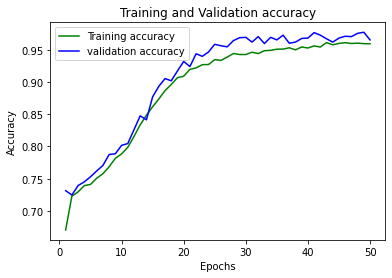

In [63]:
loss_train = hist.history['accuracy']
loss_val = hist.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()